In [1]:
#Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
#Refrence to Csv files 
cab_ride_df = pd.read_csv("Cab-Weather-Data/cab_rides.csv")
weather_df = pd.read_csv("Cab-Weather-Data/weather.csv")
 

In [3]:
# Cleaning Weather Data
# The timestamps were listed in epoch formatting, and needs to be converted to a readable date format

weather_df["date"] = pd.to_datetime(weather_df["time_stamp"], unit="s")

# Reorder the columns for readability
clean_weather_df = weather_df[["date","location","temp","clouds","pressure","rain","humidity","wind"]]


# Reset the index and change the location header to source. This is so our merge will align on common time point & weather conditions at pick up location
new_weather_df = clean_weather_df.reset_index(drop=True)
new_weather_df.rename(columns={"location":"source"}, inplace=True)
new_weather_df.head()

,date,source,temp,clouds,pressure,rain,humidity,wind
0,2018-12-16 23:45:01,Back Bay,42.42,1.0,1012.14,0.1228,0.77,11.25
1,2018-12-16 23:45:01,Beacon Hill,42.43,1.0,1012.15,0.1846,0.76,11.32
2,2018-12-16 23:45:01,Boston University,42.50,1.0,1012.15,0.1089,0.76,11.07
3,2018-12-16 23:45:01,Fenway,42.11,1.0,1012.13,0.0969,0.77,11.09
4,2018-12-16 23:45:01,Financial District,43.13,1.0,1012.14,0.1786,0.75,11.49


In [4]:
# Cleaning Car Ride Data
# The epoch timestamp in this table is represented in milliseconds, so we divide by 1000 to find the time in value of seconds
cab_ride_df["date"]=pd.to_datetime(cab_ride_df["time_stamp"]/1000, unit="s")

# Removing unwanted columns like id and product_id
clean_cab_df = cab_ride_df[["date","source","destination","distance","price","surge_multiplier","cab_type", "name"]]

# Resetting the index
new_cab_df=clean_cab_df.reset_index(drop=True)
new_cab_df.head()


,date,source,destination,distance,price,surge_multiplier,cab_type,name
0,2018-12-16 09:30:07.890000128,Haymarket Square,North Station,0.44,5.0,1.0,Lyft,Shared
1,2018-11-27 02:00:23.676999936,Haymarket Square,North Station,0.44,11.0,1.0,Lyft,Lux
2,2018-11-28 01:00:22.197999872,Haymarket Square,North Station,0.44,7.0,1.0,Lyft,Lyft
3,2018-11-30 04:53:02.749000192,Haymarket Square,North Station,0.44,26.0,1.0,Lyft,Lux Black XL
4,2018-11-29 03:49:20.223000064,Haymarket Square,North Station,0.44,9.0,1.0,Lyft,Lyft XL


In [5]:
#Merge the datesets into a single one based on time_stamp and location
cleaned_merged_df = pd.merge_asof(new_cab_df.sort_values("date"), new_weather_df.sort_values("date"), 
                            left_by=  ['source' ],right_by= ['source' ] ,
                            left_on=  ['date']   ,right_on= ['date'], tolerance=pd.Timedelta(minutes = 15 ) )
cleaned_merged_df.head()



,date,source,destination,distance,price,surge_multiplier,cab_type,name,temp,clouds,pressure,rain,humidity,wind
0,2018-11-26 03:40:46.318000128,Boston University,Theatre District,3.03,34.0,1.0,Lyft,Lux Black XL,41.07,0.86,1014.39,NaN,0.92,1.36
1,2018-11-26 03:40:46.319000064,Theatre District,North End,1.57,NaN,1.0,Uber,Taxi,40.80,0.87,1014.39,NaN,0.93,1.55
2,2018-11-26 03:40:46.319000064,South Station,Theatre District,1.30,18.5,1.0,Uber,Black,40.86,0.87,1014.39,NaN,0.93,1.60
3,2018-11-26 03:40:46.320000000,Theatre District,Fenway,2.71,19.5,1.0,Uber,UberX,40.80,0.87,1014.39,NaN,0.93,1.55
4,2018-11-26 03:40:46.320000000,Northeastern University,Beacon Hill,2.43,10.5,1.0,Lyft,Lyft,40.81,0.89,1014.35,NaN,0.93,1.36


In [6]:
#dataframe info 
cleaned_merged_df.describe


<bound method NDFrame.describe of                                 date                   source  \
0      2018-11-26 03:40:46.318000128        Boston University   
1      2018-11-26 03:40:46.319000064         Theatre District   
2      2018-11-26 03:40:46.319000064            South Station   
3      2018-11-26 03:40:46.320000000         Theatre District   
4      2018-11-26 03:40:46.320000000  Northeastern University   
...                              ...                      ...   
693066 2018-12-18 19:15:10.943000064  Northeastern University   
693067 2018-12-18 19:15:10.943000064              Beacon Hill   
693068 2018-12-18 19:15:10.943000064  Northeastern University   
693069 2018-12-18 19:15:10.943000064  Northeastern University   
693070 2018-12-18 19:15:10.943000064  Northeastern University   

             destination  distance  price  surge_multiplier cab_type  \
0       Theatre District      3.03   34.0               1.0     Lyft   
1              North End      1.57    NaN

In [7]:
# To ensure we have all rows that have weather conditions present, we want to drop all null values in the Temperature column
# Null values for rain or wind is ok because these are logical weather conditions
final_df=cleaned_merged_df.dropna(subset=["temp"])
final_df=final_df.reset_index(drop=True)

# With the null values in other rows, we can fill them with "0"
final_df.fillna(0,inplace=True)
final_df.head()

,date,source,destination,distance,price,surge_multiplier,cab_type,name,temp,clouds,pressure,rain,humidity,wind
0,2018-11-26 03:40:46.318000128,Boston University,Theatre District,3.03,34.0,1.0,Lyft,Lux Black XL,41.07,0.86,1014.39,0.0,0.92,1.36
1,2018-11-26 03:40:46.319000064,Theatre District,North End,1.57,0.0,1.0,Uber,Taxi,40.80,0.87,1014.39,0.0,0.93,1.55
2,2018-11-26 03:40:46.319000064,South Station,Theatre District,1.30,18.5,1.0,Uber,Black,40.86,0.87,1014.39,0.0,0.93,1.60
3,2018-11-26 03:40:46.320000000,Theatre District,Fenway,2.71,19.5,1.0,Uber,UberX,40.80,0.87,1014.39,0.0,0.93,1.55
4,2018-11-26 03:40:46.320000000,Northeastern University,Beacon Hill,2.43,10.5,1.0,Lyft,Lyft,40.81,0.89,1014.35,0.0,0.93,1.36


In [8]:
#Count the numbers of temp 
final_df["temp"].count

<bound method Series.count of 0         41.07
1         40.80
2         40.86
3         40.80
4         40.81
          ...  
251822    31.20
251823    30.80
251824    30.80
251825    30.91
251826    31.20
Name: temp, Length: 251827, dtype: float64>

In [9]:
# Adding the day of the week to our table to see if that may have any correlation to weather
final_df["day_of_week"]=final_df["date"].dt.day_name()
final_df.head()

,date,source,destination,distance,price,surge_multiplier,cab_type,name,temp,clouds,pressure,rain,humidity,wind,day_of_week
0,2018-11-26 03:40:46.318000128,Boston University,Theatre District,3.03,34.0,1.0,Lyft,Lux Black XL,41.07,0.86,1014.39,0.0,0.92,1.36,Monday
1,2018-11-26 03:40:46.319000064,Theatre District,North End,1.57,0.0,1.0,Uber,Taxi,40.80,0.87,1014.39,0.0,0.93,1.55,Monday
2,2018-11-26 03:40:46.319000064,South Station,Theatre District,1.30,18.5,1.0,Uber,Black,40.86,0.87,1014.39,0.0,0.93,1.60,Monday
3,2018-11-26 03:40:46.320000000,Theatre District,Fenway,2.71,19.5,1.0,Uber,UberX,40.80,0.87,1014.39,0.0,0.93,1.55,Monday
4,2018-11-26 03:40:46.320000000,Northeastern University,Beacon Hill,2.43,10.5,1.0,Lyft,Lyft,40.81,0.89,1014.35,0.0,0.93,1.36,Monday


In [10]:
#Adding Month to the table 
final_df["month"] = final_df['date'].dt.month
final_df.head()

,date,source,destination,distance,price,surge_multiplier,cab_type,name,temp,clouds,pressure,rain,humidity,wind,day_of_week,month
0,2018-11-26 03:40:46.318000128,Boston University,Theatre District,3.03,34.0,1.0,Lyft,Lux Black XL,41.07,0.86,1014.39,0.0,0.92,1.36,Monday,11
1,2018-11-26 03:40:46.319000064,Theatre District,North End,1.57,0.0,1.0,Uber,Taxi,40.80,0.87,1014.39,0.0,0.93,1.55,Monday,11
2,2018-11-26 03:40:46.319000064,South Station,Theatre District,1.30,18.5,1.0,Uber,Black,40.86,0.87,1014.39,0.0,0.93,1.60,Monday,11
3,2018-11-26 03:40:46.320000000,Theatre District,Fenway,2.71,19.5,1.0,Uber,UberX,40.80,0.87,1014.39,0.0,0.93,1.55,Monday,11
4,2018-11-26 03:40:46.320000000,Northeastern University,Beacon Hill,2.43,10.5,1.0,Lyft,Lyft,40.81,0.89,1014.35,0.0,0.93,1.36,Monday,11


In [11]:
# Formatting some columns to show accurate values
final_df["clouds"]=final_df["clouds"]*100
final_df["humidity"]=final_df["humidity"]*100


In [12]:
# Pretty-fying our final dataframe by including units of measurement for easy analysis

final_df = final_df.rename(columns={"date":"Date","day_of_week":"Weekday","source":"Pick_Up_Location","destination":"Destination",
                                    "distance":"Distance(m)","price":"Price($)","surge_multiplier":"Surge_Multiplier",
                                    "cab_type":"Rideshare_App","name":"Ride_Type","temp":"Temp(C)",
                                    "clouds":"Cloudiness(%)","pressure":"Pressure(MB)","rain":"Rainfall(in)",
                                    "humidity":"Humidity(%)","wind":"Wind_Speed(mph)"})

final_df = final_df[["Date","Weekday","Pick_Up_Location","Destination","Distance(m)","Price($)","Surge_Multiplier","Rideshare_App","Ride_Type",
                     "Temp(C)","Cloudiness(%)","Pressure(MB)","Rainfall(in)","Humidity(%)","Wind_Speed(mph)"]]
final_df.head()

,Date,Weekday,Pick_Up_Location,Destination,Distance(m),Price($),Surge_Multiplier,Rideshare_App,Ride_Type,Temp(C),Cloudiness(%),Pressure(MB),Rainfall(in),Humidity(%),Wind_Speed(mph)
0,2018-11-26 03:40:46.318000128,Monday,Boston University,Theatre District,3.03,34.0,1.0,Lyft,Lux Black XL,41.07,86.0,1014.39,0.0,92.0,1.36
1,2018-11-26 03:40:46.319000064,Monday,Theatre District,North End,1.57,0.0,1.0,Uber,Taxi,40.80,87.0,1014.39,0.0,93.0,1.55
2,2018-11-26 03:40:46.319000064,Monday,South Station,Theatre District,1.30,18.5,1.0,Uber,Black,40.86,87.0,1014.39,0.0,93.0,1.60
3,2018-11-26 03:40:46.320000000,Monday,Theatre District,Fenway,2.71,19.5,1.0,Uber,UberX,40.80,87.0,1014.39,0.0,93.0,1.55
4,2018-11-26 03:40:46.320000000,Monday,Northeastern University,Beacon Hill,2.43,10.5,1.0,Lyft,Lyft,40.81,89.0,1014.35,0.0,93.0,1.36


In [13]:
# Save the dataframe into a csv file to analyze further
final_df.to_csv("rideshare_vs_weather.csv", index=False)

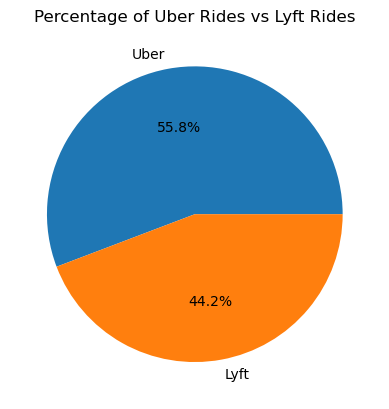

In [14]:
#Pie chart created to see the percentage of lyft rides to Uber Rides
ride_counts = final_df["Rideshare_App"].value_counts()

percentages = (ride_counts / ride_counts.sum()) * 100

plt.pie(percentages, labels=percentages.index, autopct='%1.1f%%')
plt.title('Percentage of Uber Rides vs Lyft Rides') 
plt.show()

In [15]:
#find the min and max distance of the trips to find the ranges 

maximum_distance = final_df["Distance(m)"].max()
minimum_distance = final_df["Distance(m)"].min()

print("Maximum Distance:", maximum_distance)
print("Minimum Distance:", minimum_distance)

Maximum Distance: 7.5
Minimum Distance: 0.02


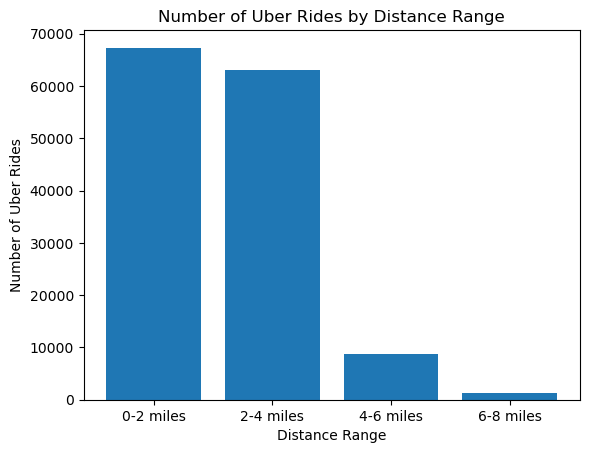

In [16]:
# Filter the DataFrame to include only Uber rides
uber_rides = final_df[final_df["Rideshare_App"] == "Uber"]

# Define the distance ranges
distance_ranges = ["0-2 miles", "2-4 miles", "4-6 miles", "6-8 miles"]

# Count the number of Uber rides within each distance range
ride_counts = [
    ((uber_rides["Distance(m)"] >= 0) & (uber_rides["Distance(m)"] <= 2)).sum(),
    ((uber_rides["Distance(m)"] > 2) & (uber_rides["Distance(m)"] <= 4)).sum(),
    ((uber_rides["Distance(m)"] > 4) & (uber_rides["Distance(m)"] <= 6)).sum(),
    ((uber_rides["Distance(m)"] > 6) & (uber_rides["Distance(m)"] <= 8)).sum()
]

# Plot the bar graph
plt.bar(distance_ranges, ride_counts)
plt.xlabel("Distance Range")
plt.ylabel("Number of Uber Rides")
plt.title("Number of Uber Rides by Distance Range")
plt.show()

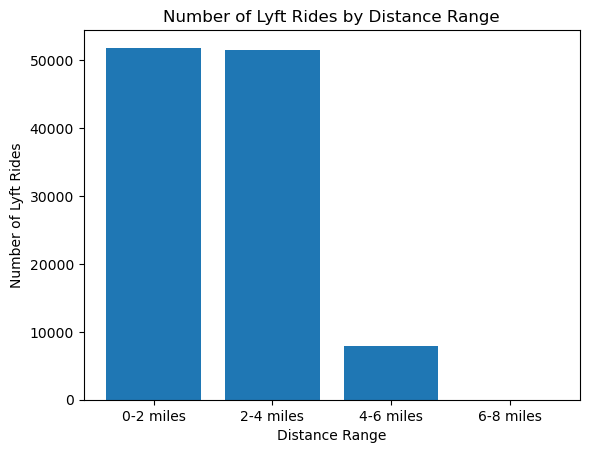

In [17]:
# Filter the DataFrame to include only Uber rides
lyft_rides = final_df[final_df["Rideshare_App"] == "Lyft"]

# Define the distance ranges
distance_ranges = ["0-2 miles", "2-4 miles", "4-6 miles", "6-8 miles"]

# Count the number of Uber rides within each distance range
ride_counts = [
    ((lyft_rides["Distance(m)"] >= 0) & (lyft_rides["Distance(m)"] <= 2)).sum(),
    ((lyft_rides["Distance(m)"] > 2) & (lyft_rides["Distance(m)"] <= 4)).sum(),
    ((lyft_rides["Distance(m)"] > 4) & (lyft_rides["Distance(m)"] <= 6)).sum(),
    ((lyft_rides["Distance(m)"] > 6) & (lyft_rides["Distance(m)"] <= 8)).sum()
]

# Plot the bar graph
plt.bar(distance_ranges, ride_counts)
plt.xlabel("Distance Range")
plt.ylabel("Number of Lyft Rides")
plt.title("Number of Lyft Rides by Distance Range")
plt.show()

In [18]:
# Total revenue for both lyft and uber
revenue_df=final_df.groupby("Rideshare_App")["Price($)"].sum()
revenue_df


Rideshare_App
Lyft    1930455.15
Uber    1902764.00
Name: Price($), dtype: float64

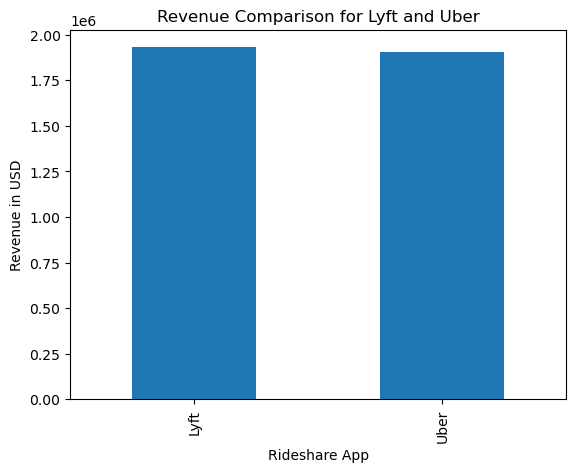

In [19]:
#Bar plot showing the revenue base on both rideshare apps
revenue_df.plot(kind='bar')
plt.title("Revenue Comparison for Lyft and Uber")
plt.xlabel("Rideshare App")
plt.ylabel("Revenue in USD")
plt.show()

In [20]:
#Monthly Revenue of each rideshare app
lyft=final_df[final_df["Rideshare_App"]=="Lyft"]
lyft_monthly_rev=lyft.groupby("month")["Price($)"].sum()
lyft_monthly_rev

KeyError: 'month'

In [ ]:
uber=final_df[final_df["Rideshare_App"]=="Uber"]
uber_monthly_rev=uber.groupby(["month"])["Price($)"].sum()
uber_monthly_rev

In [21]:
#Created Dataframe to show revenue based on each rideshare app
monthly_rev_df=pd.DataFrame({"Lyft":lyft_monthly_rev,"Uber":uber_monthly_rev})
monthly_rev_df

NameError: name 'lyft_monthly_rev' is not defined

In [22]:
#Bar chart to show revenue based on months
ax=monthly_rev_df.plot.bar()
labels=['Nov','Dec']
ax.set_xticklabels(labels)
plt.title("Monthly Revenue Comparison for Lyft and Uber")
plt.xlabel("Rideshare App")
plt.ylabel("Revenue in USD")
plt.show()

NameError: name 'monthly_rev_df' is not defined

In [23]:
# higehst pay of each day for uber 
uber_ridecounts=final_df[final_df["Rideshare_App"]=="Uber"]
uber_highestday_price=uber_ridecounts.groupby(["Weekday"])["Price($)"].max()
uber_highestday_price

Weekday
Friday       89.5
Monday       64.5
Saturday     60.5
Sunday       57.5
Thursday     81.5
Tuesday      64.0
Wednesday    68.0
Name: Price($), dtype: float64

In [24]:
# higehst pay of each day for lyft 
lyft_ridecounts=final_df[final_df["Rideshare_App"]=="Lyft"]
lyft_highestday_price=lyft_ridecounts.groupby(["Weekday"])["Price($)"].max()
lyft_highestday_price

Weekday
Friday       89.0
Monday       92.0
Saturday     87.5
Sunday       80.0
Thursday     92.0
Tuesday      80.5
Wednesday    92.0
Name: Price($), dtype: float64

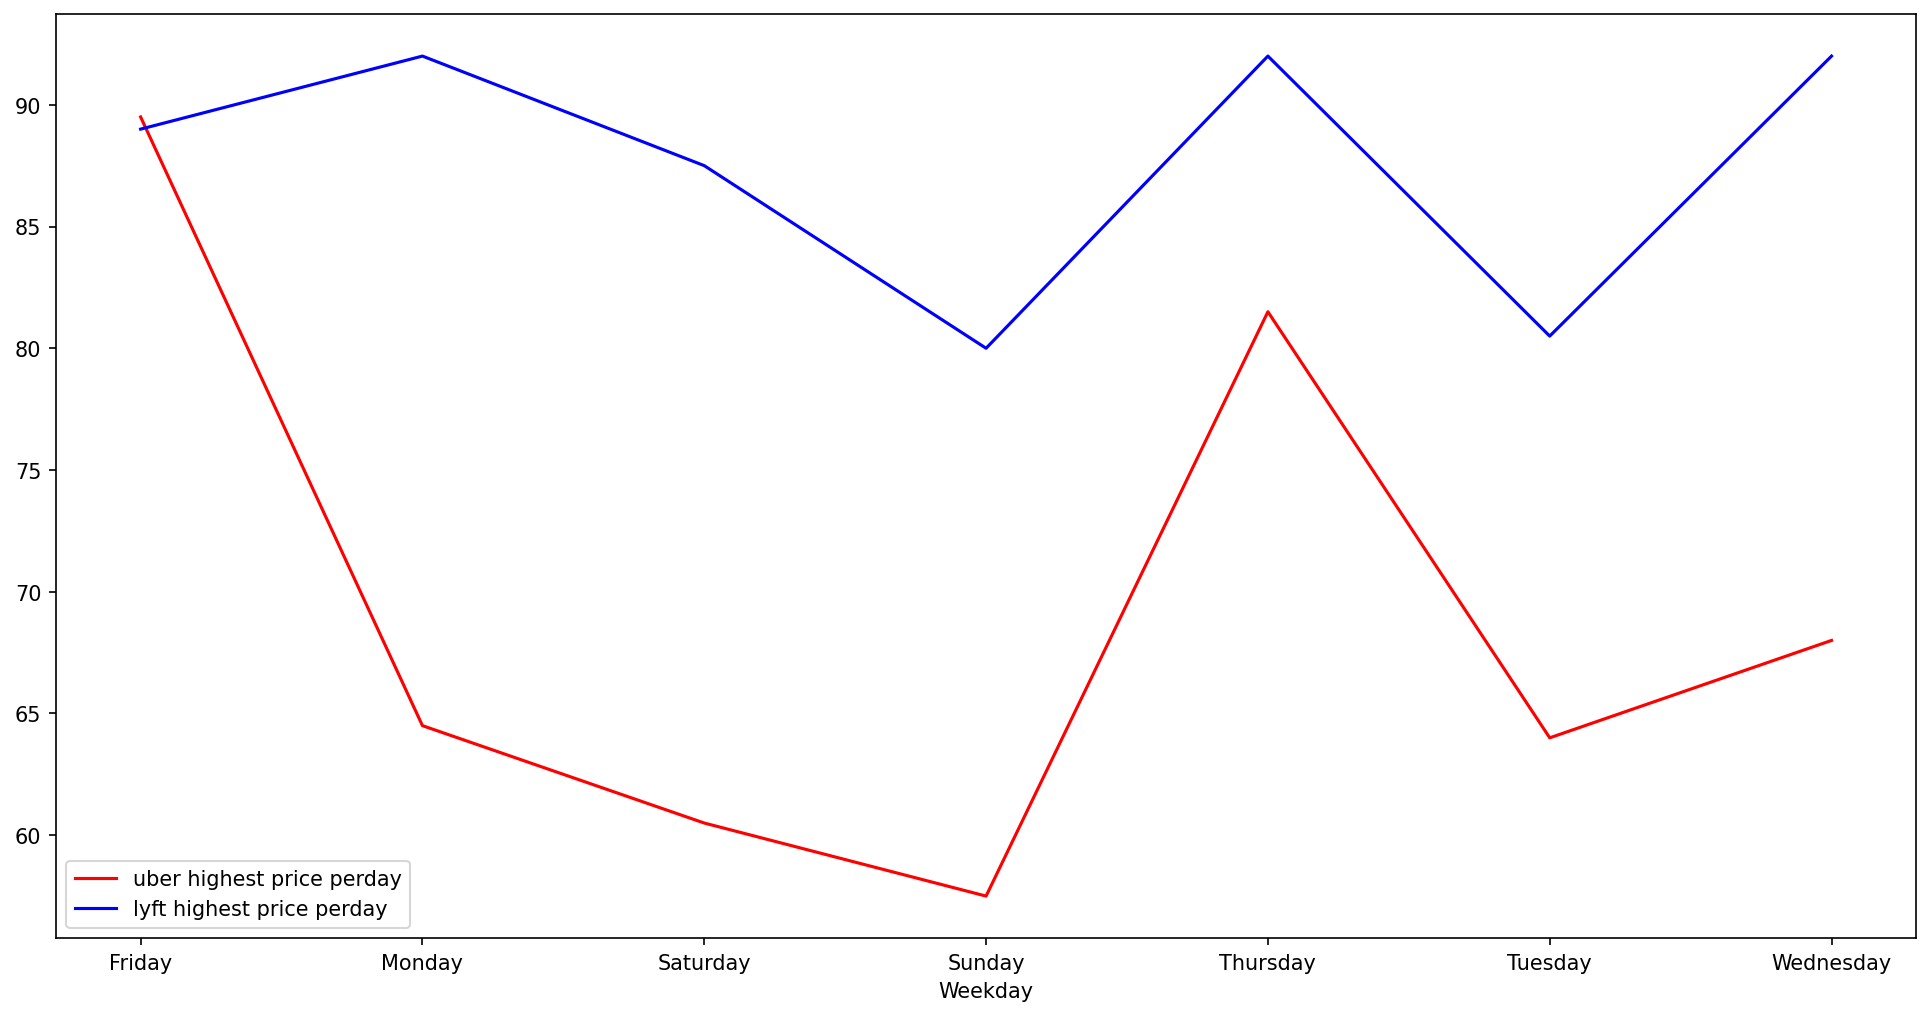

In [25]:
#created the line chart to show the comparison 
plt.figure(figsize=(16, 8), dpi=150)
uber_highestday_price.plot(color ="r", label ="uber highest price perday")
lyft_highestday_price.plot(color ="b", label ="lyft highest price perday")
plt.legend()

In [26]:
########## MIKE ################

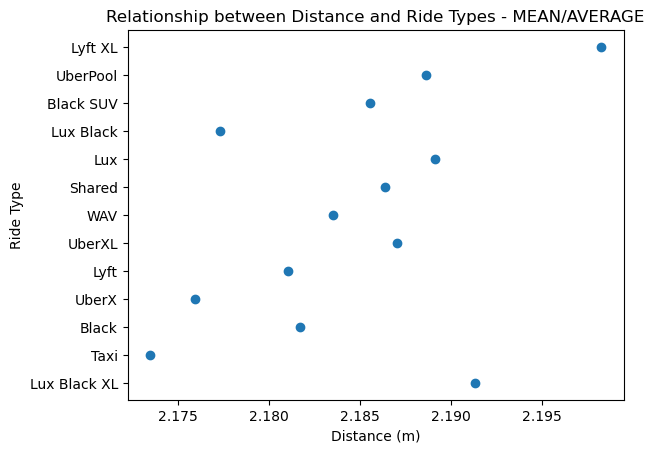

In [29]:
# MIKE - SCATTER PLOT
# Calculate the mean distance for each ride type
ride_types = final_df["Ride_Type"].unique()
mean_distances = final_df.groupby("Ride_Type")["Distance(m)"].mean()

# Plot the scatter plot
plt.scatter(mean_distances, ride_types)
plt.xlabel("Distance (m)")
plt.ylabel("Ride Type")
plt.title("Relationship between Distance and Ride Types - MEAN/AVERAGE")
plt.show()

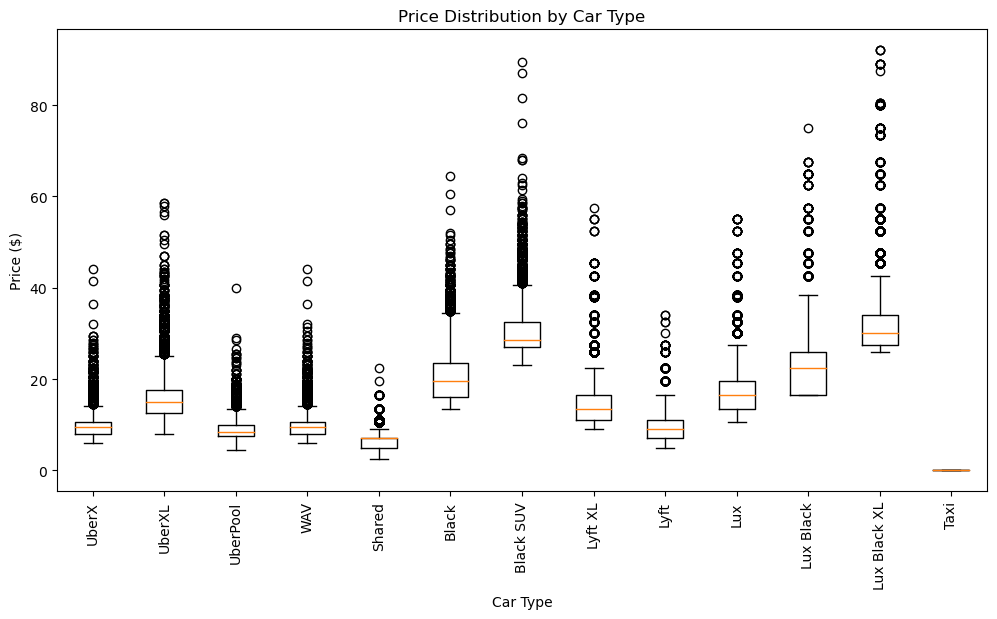

In [30]:
# MIKE
# Step 1: Reference each unique car type
unique_car_types = [ 'UberX', 'UberXL', 'UberPool', 'WAV', 'Shared', 'Black', 'Black SUV', 'Lyft XL', 'Lyft', 'Lux', 'Lux Black', 'Lux Black XL', 'Taxi']

# Step 2: Collect prices for each unique car type
car_type_prices = []
for car_type in unique_car_types:
    prices = final_df.loc[final_df['Ride_Type'] == car_type, 'Price($)']
    car_type_prices.append(prices)

# Step 3: Create box-and-whisker plot for all unique car types
plt.figure(figsize=(12, 6))  # Adjust the figure size to be wider (12 units wide, 6 units tall)
plt.boxplot(car_type_prices, labels=unique_car_types)
plt.title('Price Distribution by Car Type')
plt.xlabel('Car Type')
plt.ylabel('Price ($)')
plt.xticks(rotation=90)
plt.show()

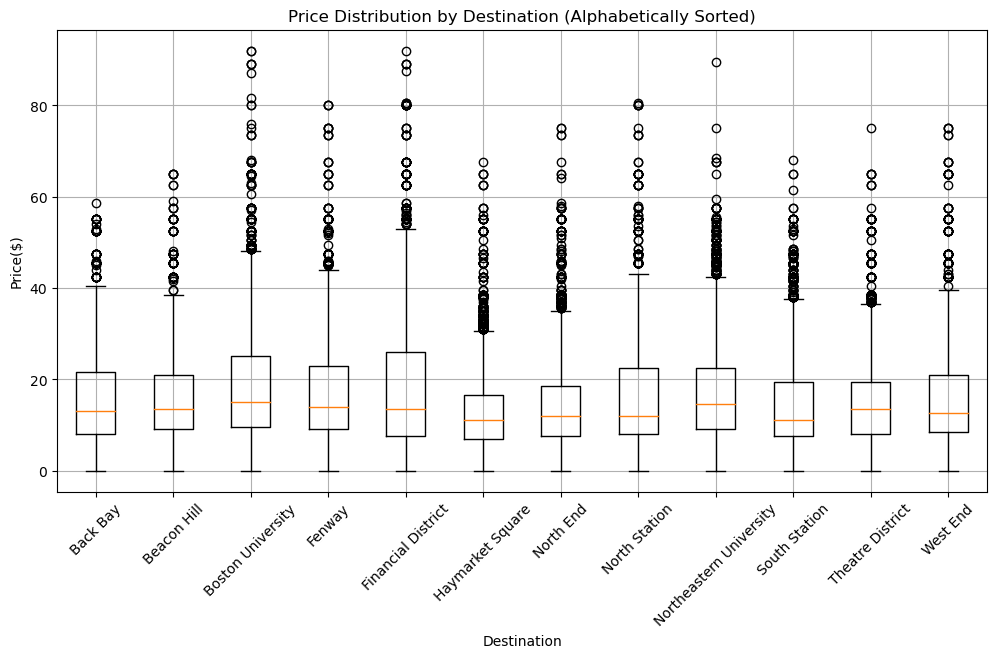

In [31]:
# MIKE
# Extract destination locations and sort alphabetically
destinations = sorted(final_df["Destination"].unique())

# Create a dictionary to store destination prices
destination_prices = {}

# Iterate over each destination
for destination in destinations:
    # Filter rows for the current destination
    destination_data = final_df[final_df["Destination"] == destination]
    # Get the prices for the current destination
    prices = destination_data["Price($)"].values
    # Store the prices in the dictionary
    destination_prices[destination] = prices

# Create a box-and-whisker plot
plt.figure(figsize=(12, 6))
plt.boxplot(destination_prices.values())
plt.xticks(range(1, len(destinations) + 1), destinations, rotation=45)
plt.xlabel("Destination")
plt.ylabel("Price($)")
plt.title("Price Distribution by Destination (Alphabetically Sorted)")
plt.grid(True)

# Display the plot
plt.show()


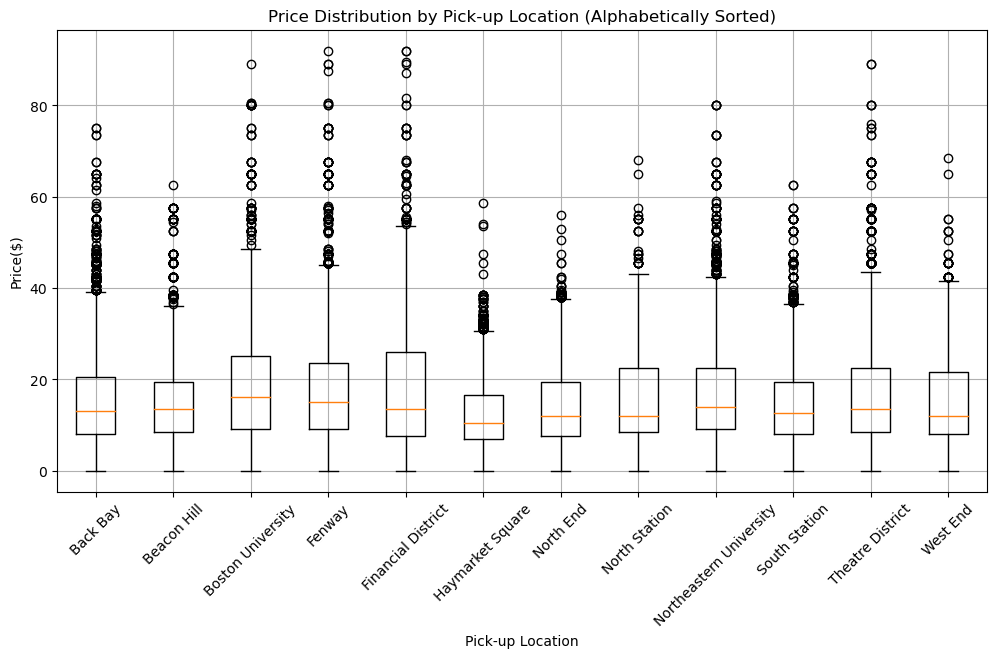

In [32]:
# MIKE
# Extract pick-up locations and sort alphabetically
pickup_locations = sorted(final_df["Pick_Up_Location"].unique())

# Create a dictionary to store pick-up location prices
pickup_prices = {}

# Iterate over each pick-up location
for pickup_location in pickup_locations:
    # Filter rows for the current pick-up location
    pickup_data = final_df[final_df["Pick_Up_Location"] == pickup_location]
    # Get the prices for the current pick-up location
    prices = pickup_data["Price($)"].values
    # Store the prices in the dictionary
    pickup_prices[pickup_location] = prices

# Create a box-and-whisker plot
plt.figure(figsize=(12, 6))
plt.boxplot(pickup_prices.values())
plt.xticks(range(1, len(pickup_locations) + 1), pickup_locations, rotation=45)
plt.xlabel("Pick-up Location")
plt.ylabel("Price($)")
plt.title("Price Distribution by Pick-up Location (Alphabetically Sorted)")
plt.grid(True)

# Display the plot
plt.show()

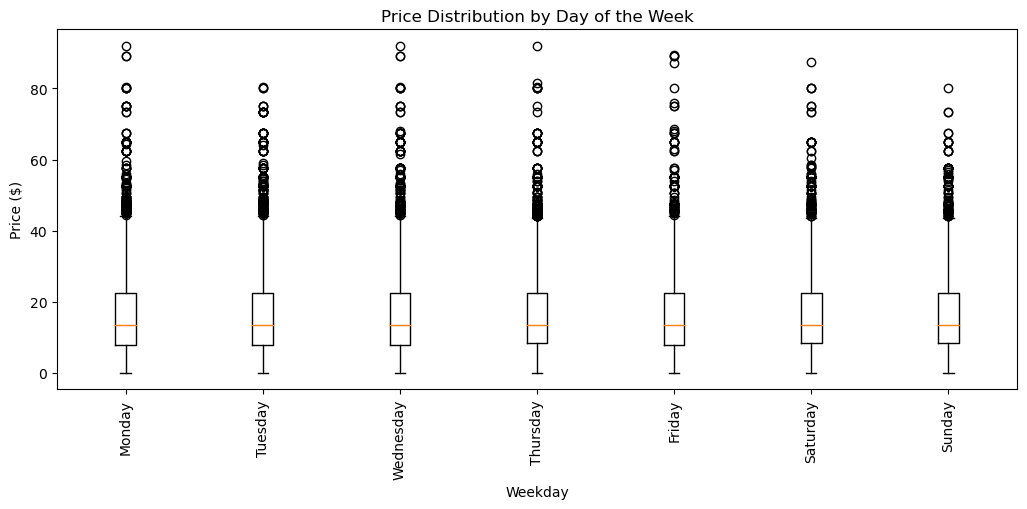

In [39]:
# MIKE - Price Distribution by Day of the Week

# Convert 'Weekday' column to categorical data type with desired order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
final_df['Weekday'] = pd.Categorical(final_df['Weekday'], categories=weekday_order, ordered=True)

# Reference each unique day of the week
unique_weekdays = final_df['Weekday'].unique()

# Create box-and-whisker plot for each unique day of the week
plt.figure(figsize=(12, 6))  # Adjust the figure size to be wider (12 units wide, 6 units tall)

# Adjust spacing between boxplots
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.3)

for i, weekday in enumerate(unique_weekdays):
    prices = final_df.loc[final_df['Weekday'] == weekday, 'Price($)']
    plt.boxplot(prices, positions=[i])

plt.title('Price Distribution by Day of the Week')
plt.xlabel('Weekday')
plt.ylabel('Price ($)')
plt.xticks(range(len(unique_weekdays)), unique_weekdays, rotation=90)
plt.show()

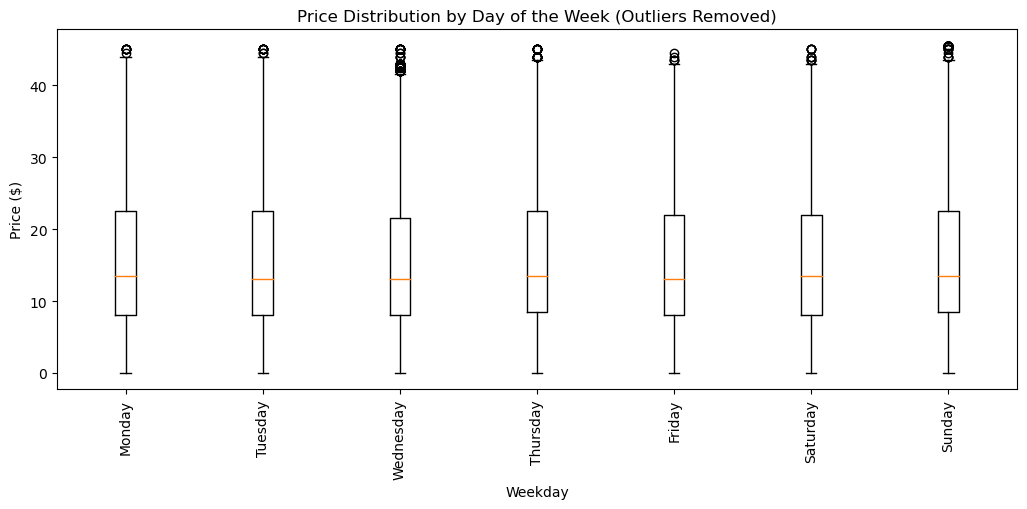

In [42]:
# MIKE - Price Distribution by Day of the Week // Z-SCORE Incorporated

# Convert 'Weekday' column to categorical data type with desired order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
final_df['Weekday'] = pd.Categorical(final_df['Weekday'], categories=weekday_order, ordered=True)

# Reference each unique day of the week
unique_weekdays = final_df['Weekday'].unique()

# Create box-and-whisker plot for each unique day of the week
plt.figure(figsize=(12, 6))  # Adjust the figure size to be wider (12 units wide, 6 units tall)

# Adjust spacing between boxplots
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.3)

for i, weekday in enumerate(unique_weekdays):
    prices = final_df.loc[final_df['Weekday'] == weekday, 'Price($)']

    # Calculate Z-score for each price
    z_scores = (prices - np.mean(prices)) / np.std(prices)

    # Set threshold for outliers (e.g., Z-score > 3 or Z-score < -3)
    threshold = 3

    # Remove outliers based on the Z-score method
    filtered_prices = prices[(z_scores <= threshold) & (z_scores >= -threshold)]

    plt.boxplot(filtered_prices, positions=[i])

plt.title('Price Distribution by Day of the Week (Outliers Removed)')
plt.xlabel('Weekday')
plt.ylabel('Price ($)')
plt.xticks(range(len(unique_weekdays)), unique_weekdays, rotation=90)
plt.show()


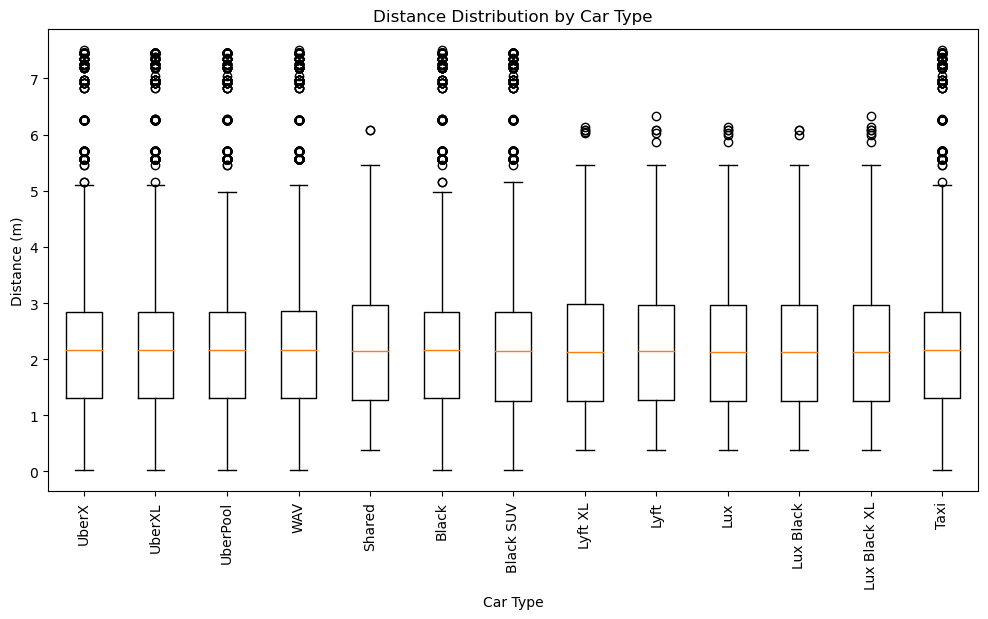

In [43]:
# MIKE
# Step 1: Reference each unique car type
unique_car_types = ['UberX', 'UberXL', 'UberPool', 'WAV', 'Shared', 'Black', 'Black SUV', 'Lyft XL', 'Lyft', 'Lux', 'Lux Black', 'Lux Black XL', 'Taxi']

# Step 2: Collect distances for each unique car type
car_type_distances = []
for car_type in unique_car_types:
    distances = final_df.loc[final_df['Ride_Type'] == car_type, 'Distance(m)']
    car_type_distances.append(distances)

# Step 3: Create box-and-whisker plot for all unique car types
plt.figure(figsize=(12, 6))  # Adjust the figure size to be wider (12 units wide, 6 units tall)
plt.boxplot(car_type_distances, labels=unique_car_types)
plt.title('Distance Distribution by Car Type')
plt.xlabel('Car Type')
plt.ylabel('Distance (m)')
plt.xticks(rotation=90)
plt.show()

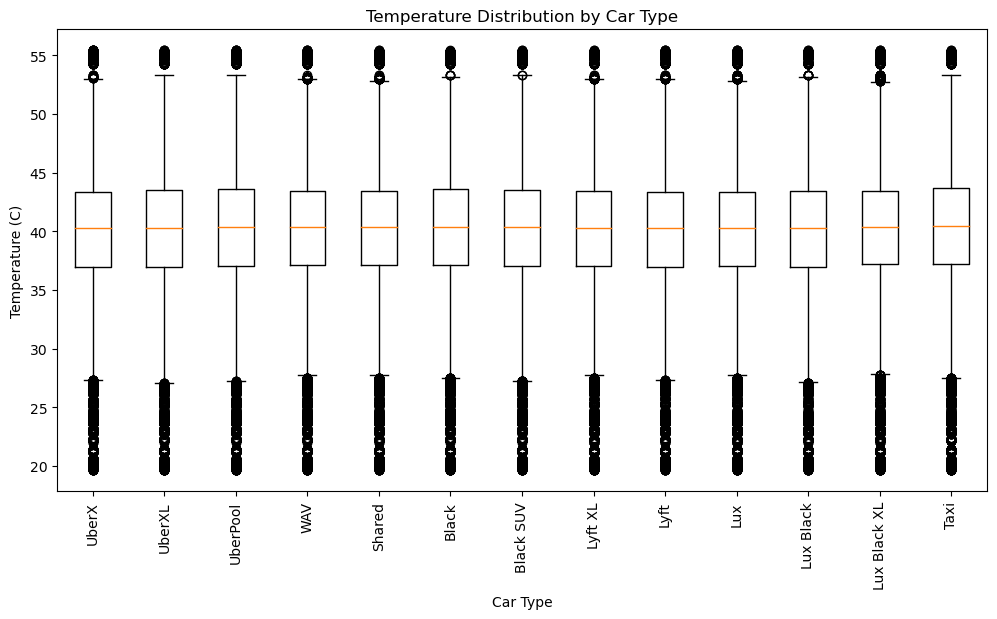

In [34]:
# MIKE
# Step 1: Reference each unique car type
unique_car_types = ['UberX', 'UberXL', 'UberPool', 'WAV', 'Shared', 'Black', 'Black SUV', 'Lyft XL', 'Lyft', 'Lux', 'Lux Black', 'Lux Black XL', 'Taxi']

# Step 2: Collect temperatures for each unique car type
car_type_temperatures = []
for car_type in unique_car_types:
    temperatures = final_df.loc[final_df['Ride_Type'] == car_type, 'Temp(C)']
    car_type_temperatures.append(temperatures)

# Step 3: Create box-and-whisker plot for all unique car types
plt.figure(figsize=(12, 6))  # Adjust the figure size to be wider (12 units wide, 6 units tall)
plt.boxplot(car_type_temperatures, labels=unique_car_types)
plt.title('Temperature Distribution by Car Type')
plt.xlabel('Car Type')
plt.ylabel('Temperature (C)')
plt.xticks(rotation=90)
plt.show()

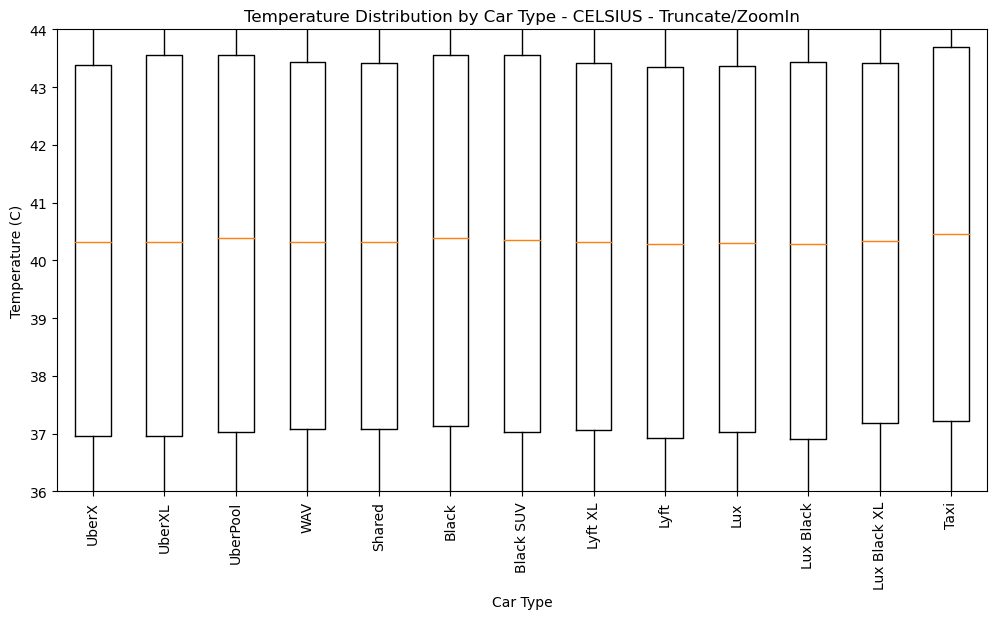

In [35]:
# MIKE
# Step 1: Reference each unique car type
unique_car_types = ['UberX', 'UberXL', 'UberPool', 'WAV', 'Shared', 'Black', 'Black SUV', 'Lyft XL', 'Lyft', 'Lux', 'Lux Black', 'Lux Black XL', 'Taxi']

# Step 2: Collect temperatures for each unique car type
car_type_temperatures = []
for car_type in unique_car_types:
    temperatures = final_df.loc[final_df['Ride_Type'] == car_type, 'Temp(C)']
    car_type_temperatures.append(temperatures)

# Step 3: Create box-and-whisker plot for all unique car types
plt.figure(figsize=(12, 6))  # Adjust the figure size to be wider (12 units wide, 6 units tall)
plt.boxplot(car_type_temperatures, labels=unique_car_types)
plt.title('Temperature Distribution by Car Type - CELSIUS - Truncate/ZoomIn')
plt.xlabel('Car Type')
plt.ylabel('Temperature (C)')
plt.xticks(rotation=90)
plt.ylim(36, 44)  # Set the y-axis limits to truncate the chart between 35 and 45 degrees
plt.show()

In [ ]:
# MIKE - remove all Ride_Type except "UberX"

# Filter the DataFrame to include only "UberX" in "Ride_Type"
new_UberXsolo_df = final_df[final_df['Ride_Type'] == 'UberX'].copy()

# Print the new DataFrame
new_UberXsolo_df

In [ ]:
# MIKE - plot "UberX" Ride_Type
# Convert the 'Date' column to datetime type
new_UberXsolo_df['Date'] = pd.to_datetime(new_UberXsolo_df['Date'])

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the Price over time
plt.plot(new_UberXsolo_df['Date'], new_UberXsolo_df['Price($)'])

# Set the labels and title
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title('Price Over Time - UBER X')

# Rotate and align the x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.show()

In [ ]:
# MIKE - plot Distinct Ride Types, Price in Y-Axis

# Convert the 'Date' column to datetime type
final_df['Date'] = pd.to_datetime(final_df['Date'])

# Get unique ride types
ride_types = final_df['Ride_Type'].unique()

# Iterate over ride types
for ride_type in ride_types:
    # Filter the DataFrame for the current ride type
    new_df = final_df[final_df['Ride_Type'] == ride_type].copy()

    # Set the figure size
    plt.figure(figsize=(10, 6))

    # Plot the Price over time for the current ride type
    plt.plot(new_df['Date'], new_df['Price($)'])

    # Set the labels and title
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.title(f'Price Over Time - {ride_type}')

    # Rotate and align the x-axis labels for better visibility
    plt.xticks(rotation=45, ha='right')

    # Display the plot
    plt.show()
